### فراخوانی کتابخانه های مورد نیاز

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt

# connecting to sql database
import mysql.connector

# to determin how much we're accomplished
from tqdm import tqdm

import numpy as np
import pandas as pd

# DATA INITIALIZATION

In [2]:
class DataProcessor:
    '''
    This class is responssible to process .txt data. Things such as:
        1. converting to dataframe
        2. removing null and missed values
        3. ...
    '''
    
    def __init__(self, file_name):

        self.file_name = file_name
        self.loader()
    
    
    def file_reader(self):
        '''reading and showing input file'''
        with open(self.file_name, 'r') as file_:
            data = file_.read()
            # print(data)
    

    def to_df(self):
        '''convert to dataframe'''
        self.df = pd.read_csv(self.file_name, 
                              sep=" ", header=None)

    def dirty_df(self):
        return self.df
    
    
    def request_method_url_seprator(self):
        '''saving values from request method and url into lists'''
        col = 5
        self.requests = []
        self.urls = []
        
        for da in range(len(self.df)):
            # seperating data into request and url
            data = self.df[col][da].split(' /') # here ---> ['DELETE', 'index.html?product_id=585&user_id=218 HTTP/1.1']
            # url
            self.urls.append('/' + data[1])
            # request
            self.requests.append(data[0])
    
    
    @staticmethod
    def timestamp_initializer(df, col1, col2):
        '''
        this function combine columns 3 and 4 which are timestamp and UTCOFFSET and returns a list
        like so:
            input date   ===> [25/Jun/2024:00:06:22	+0000] | HERE timestamp and UTC OFFSET are seperated!
            data         ===> '25/Jun/2024:00:06:22 +0000'
            output data  ===> '2024-06-24 07:04:22+00:00'  | which its data type is datetime.datetime
        output data is datetime + UTCOFFSET and then it's ready
        to be stored in the SQL database.  
        '''
        result = []
        for d in range(len(df)):
            date = df[col1][d][1:] + ' ' + df[col2][d][:-1]
            converted_to_datetime = datetime.strptime(date, "%d/%b/%Y:%H:%M:%S %z")
            result.append(converted_to_datetime)
        return result

    
    def give_timestamp(self):
        self.timestamp = self.timestamp_initializer(self.df, 3, 4)
    
    
    @staticmethod
    def df2list(df, col):
        data_list = []
        for n in range(len(df)):
            data_list.append(df[col][n])
        return data_list
    
    def col_initilizer(self):
        self.status_code = self.df2list(self.df, 6)
        self.response_size = self.df2list(self.df, 7)
        self.ip_address = self.df2list(self.df, 0)
        

    def create_dataset(self):
        self.dataset = {
            'IP address': self.ip_address,
            'timestamp': self.timestamp,
            'request method': self.requests,
            'URL': self.urls,
            'status code': self.status_code,
            'response size (bytes)': self.response_size
        }

        self.new_df = pd.DataFrame(self.dataset)
        print(self.new_df.head())
        
    
    #################################### CLEAN SECTION ##################################
    # cleaning null values
    def null_cleaner(self):
        print('#################################################')
        print("Here you can see number of null values in each column!")
        print(f'------------->\n{self.new_df.isnull().sum()}')
        print('\ncleaning null values ...\n')
        # removing null values
        self.new_df.dropna(inplace=True)
        print("Here you can see number of null values after cleaning them in each column!")
        print(f'------------->\n{self.new_df.isnull().sum()}')
        print('#################################################')
        print()
    
    
    '''
    NOTE: Here I found something like '-' in response seize column
          which is very unsuall!
    '''
    def clean_hyphen(self):
        # finding index of all - values
        index_missed_values = self.new_df[self.new_df['response size (bytes)'] == '-'].index
        len(index_missed_values) # number of - values
        # drop them from dataframe
        self.new_df.drop(index_missed_values, inplace=True)
    
    
    def loader(self):
        self.file_reader()
        self.to_df()
        self.request_method_url_seprator()
        self.give_timestamp()
        self.col_initilizer()
        
        # creating new dataset
        self.create_dataset()
        self.null_cleaner()
        self.clean_hyphen()
        
        print('#################################################')
        print('Congradulations!\nDataset is ready and cleaned!')
        print('#################################################')
    
    def give_df(self):
        return self.new_df

In [3]:
dp = DataProcessor('nginx_logs - Copy.txt')

       IP address                 timestamp request method  \
0  74.240.191.221 2024-06-25 00:06:22+00:00         DELETE   
1     15.89.35.67 2024-06-24 04:43:22+00:00            PUT   
2   158.20.204.46 2024-06-21 14:54:22+00:00            GET   
3   158.20.204.46 2024-06-21 14:54:22+00:00            GET   
4  238.189.173.32 2024-06-21 21:33:22+00:00            GET   

                                                 URL  status code  \
0    /index.html?product_id=585&user_id=218 HTTP/1.1          200   
1  /index.html?session_id=def456&session_id=mno34...          301   
2           /contact.html?session_id=def456 HTTP/1.1          200   
3           /contact.html?session_id=def456 HTTP/1.1          200   
4  /signup?session_id=abc123&session_id=ghi789 HT...          500   

  response size (bytes)  
0                  1974  
1                  4349  
2                  4060  
3                  4060  
4                  2661  
#################################################
Here y

In [4]:
# dirty df
dirty_df = dp.dirty_df()
dirty_df.head()

,0,1,2,3,4,5,6,7
0,74.240.191.221,-,-,[25/Jun/2024:00:06:22,+0000],DELETE /index.html?product_id=585&user_id=218 ...,200,1974
1,15.89.35.67,-,-,[24/Jun/2024:04:43:22,+0000],PUT /index.html?session_id=def456&session_id=m...,301,4349
2,158.20.204.46,-,-,[21/Jun/2024:14:54:22,+0000],GET /contact.html?session_id=def456 HTTP/1.1,200,4060
3,158.20.204.46,-,-,[21/Jun/2024:14:54:22,+0000],GET /contact.html?session_id=def456 HTTP/1.1,200,4060
4,238.189.173.32,-,-,[21/Jun/2024:21:33:22,+0000],GET /signup?session_id=abc123&session_id=ghi78...,500,2661


In [76]:
df = dp.give_df()
df.head()

,IP address,timestamp,request method,URL,status code,response size (bytes)
0,74.240.191.221,2024-06-25 00:06:22+00:00,DELETE,/index.html?product_id=585&user_id=218 HTTP/1.1,200,1974
1,15.89.35.67,2024-06-24 04:43:22+00:00,PUT,/index.html?session_id=def456&session_id=mno34...,301,4349
2,158.20.204.46,2024-06-21 14:54:22+00:00,GET,/contact.html?session_id=def456 HTTP/1.1,200,4060
3,158.20.204.46,2024-06-21 14:54:22+00:00,GET,/contact.html?session_id=def456 HTTP/1.1,200,4060
4,238.189.173.32,2024-06-21 21:33:22+00:00,GET,/signup?session_id=abc123&session_id=ghi789 HT...,500,2661


<hr>

# DATABASE

In [83]:
class DataBase:
    
    def __init__(self, host, user, password, database=None):
        self.host = host
        self.user = user
        self.password = password
        self.database = database
        self.connect()

    
    def connect(self):
        try:
            self.db = mysql.connector.connect(
                host = self.host,
                user = self.user,
                password = self.password,
            )
            self.cursor = self.db.cursor()
            print('connected to database!')
        except Exception as e:
            print(e)
    
    
    def query_executer(self, sql, val=None):
        try:
            self.cursor.execute(sql, val)
            try:
                data = self.cursor.fetchall()
                if len(data) != 0:
                    return data
            except Exception as e:
                print(e)
        except Exception as e:
            print(e)
    
    
    def commit(self):
        try:
            self.db.commit()
        except Exception as e:
            print(e)
    
    # def show_databases(self):
    #     sql = 'SHOW DATABASES;'
    #     return self.query_executer(sql)
    
    
    # def create_database(self, db_name):
    #     self.db_name = db_name
    #     sql = f'CREATE DATABASE IF NOT EXISTS {self.db_name};'
    #     self.query_executer(sql)
    #     print(f'database {self.db_name} created successfully!')
    
    
    
    # def create_table(self, sql):
    #     self.query_executer(sql)
    #     print('table created successfully!')

In [84]:
db = DataBase('localhost', 'admin', '1234')

connected to database!


In [85]:
# show databases
db.query_executer('show databases;')

[('information_schema',),
 ('mysql',),
 ('performance_schema',),
 ('sakila',),
 ('sys',),
 ('world',)]

In [86]:
db.query_executer('create database if not exists test;')

In [87]:
db.query_executer('show databases;')

[('information_schema',),
 ('mysql',),
 ('performance_schema',),
 ('sakila',),
 ('sys',),
 ('test',),
 ('world',)]

In [88]:
# create table

sql = """
            CREATE TABLE IF NOT EXISTS Ngnix(
                id INT AUTO_INCREMENT,
                IP_address VARCHAR(255),
                timestamp TIMESTAMP,
                request_method VARCHAR(255),
                url VARCHAR(255),
                status_code INT NOT NULL,
                response_size INT NOT NULL,
                PRIMARY KEY (id)
            );
    """
    
db.query_executer('use test')
db.query_executer(sql)

In [89]:
db.query_executer('show tables')

[('ngnix',)]

In [90]:
for n in tqdm(range(len(df))):
    try:
        data = df.iloc[n, :]
        sql =  '''
            INSERT INTO Ngnix (IP_address, timestamp, request_method, url, status_code, response_size)
            VALUES (%s, %s, %s, %s, %s, %s);
        '''
        val = (data['IP address'], data['timestamp'], data['request method'], data['URL'], int(data['status code']), data['response size (bytes)'])
        db.query_executer(sql, val)
        db.commit()
        # print('data added!')
    except Exception as e:
        print()
        print(data)
        print()
        print(e)

100%|██████████| 1014/1014 [00:01<00:00, 609.43it/s]


In [91]:
db_data = db.query_executer('select * from ngnix;')

In [92]:
db_data[1]

(2,
 '15.89.35.67',
 datetime.datetime(2024, 6, 24, 4, 43, 22),
 'PUT',
 '/index.html?session_id=def456&session_id=mno345&user_id=709 HTTP/1.1',
 301,
 4349)

<!DOCTYPE html>
<html>
    <body>

<h1>Stored Data in MySQL | database name is test</h1>

<img src="sql_img.png" alt="Girl in a jacket" width="1610" height="690">

</body>
</html>

<hr>

## Data Visualization | Data Is Loaded From the Database

#### different types of request methods in PI and BAR graph

In [93]:
sql = "SELECT request_method FROM Ngnix;"
sql_reqest_methods = db.query_executer(sql)
sql_reqest_methods[:2]

[('DELETE',), ('PUT',)]

In [94]:
# using method query_executer from Database class in function below
def sql_executer_with_condition(sql_command, condition=None):
    try:
        result = db.query_executer(sql_command, condition)
        if len(result) != 0:
            return result
    except Exception as e:
        print(e)

In [95]:
# working only with non duplicated values
sql_reqest_methods = list(set(sql_reqest_methods))

In [96]:
rq_methods = []
for da in sql_reqest_methods:
    rq_methods.append(da[0])
rq_methods

['GET', 'DELETE', 'POST', 'PUT']

In [97]:
sql_delete = sql_executer_with_condition('SELECT COUNT(*) FROM Ngnix WHERE request_method = %s', ['DELETE'])
sql_post = sql_executer_with_condition('SELECT COUNT(*) FROM Ngnix WHERE request_method = %s', ['POST'])
sql_get = sql_executer_with_condition('SELECT COUNT(*) FROM Ngnix WHERE request_method = %s', ['GET'])
sql_put = sql_executer_with_condition('SELECT COUNT(*) FROM Ngnix WHERE request_method = %s', ['PUT'])
num_rq_method = [sql_delete[0][0], sql_post[0][0], sql_get[0][0], sql_put[0][0]]
num_rq_method

[268, 228, 246, 272]

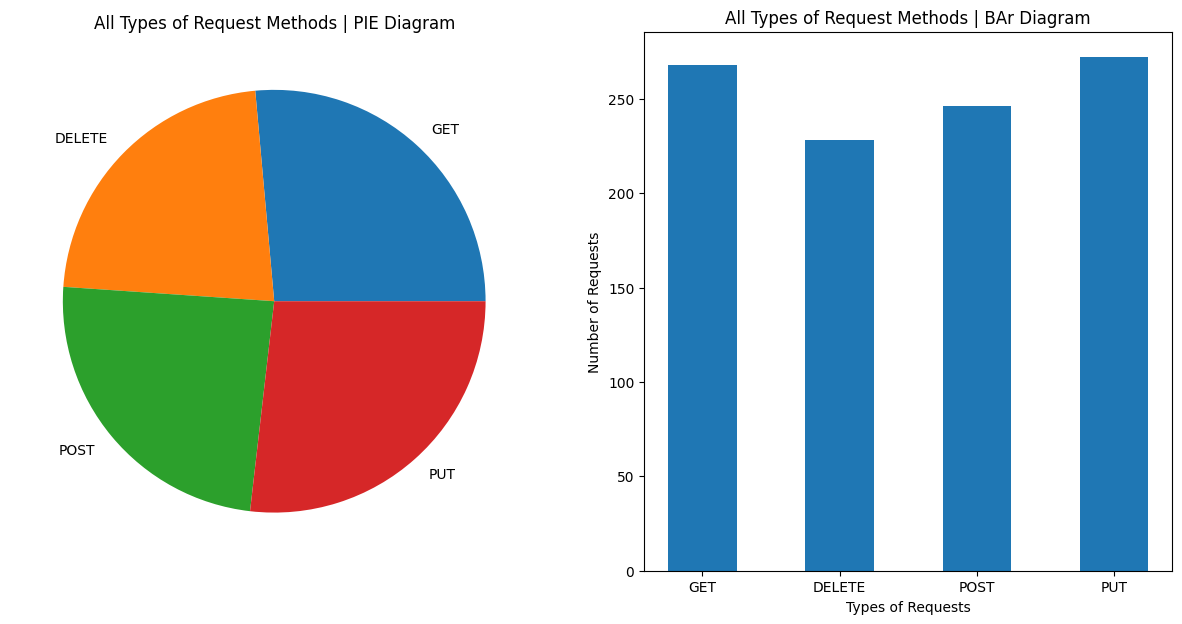

In [98]:
fig = plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title('All Types of Request Methods | PIE Diagram')
plt.pie(num_rq_method, labels=rq_methods)

plt.subplot(1, 2, 2)
plt.bar(rq_methods, num_rq_method, width=0.5)
plt.ylabel('Number of Requests')
plt.xlabel('Types of Requests')
plt.title('All Types of Request Methods | BAr Diagram')
 
# show plot
plt.show()

#### --------------------------------------------------------------------------------------------------------------------

In [100]:
sql_timestamp = db.query_executer('select timestamp from ngnix;')
sql_timestamp[:6]

[(datetime.datetime(2024, 6, 25, 0, 6, 22),),
 (datetime.datetime(2024, 6, 24, 4, 43, 22),),
 (datetime.datetime(2024, 6, 21, 14, 54, 22),),
 (datetime.datetime(2024, 6, 21, 14, 54, 22),),
 (datetime.datetime(2024, 6, 21, 21, 33, 22),),
 (datetime.datetime(2024, 6, 26, 9, 3, 22),)]

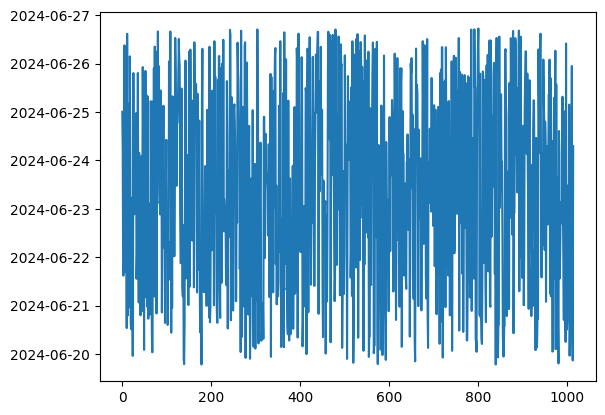

In [101]:
plt.plot(sql_timestamp)

In [109]:
sql_timestamp = np.array(sql_timestamp)
sql_timestamp.shape

(1014, 1)

In [111]:
sql_response_size = db.query_executer('select response_size from ngnix;')
sql_response_size[:6]

[(1974,), (4349,), (4060,), (4060,), (2661,), (629,)]

In [113]:
temp = []

for i in sql_response_size:
    temp.append(i[0])

sql_response_size = temp

In [115]:
sql_response_size = np.array(sql_response_size)
sql_response_size = sql_response_size.reshape(sql_response_size.shape[0], 1)
sql_response_size.shape

(1014, 1)

Text(0.5, 1.0, 'Response Size | Histogram')

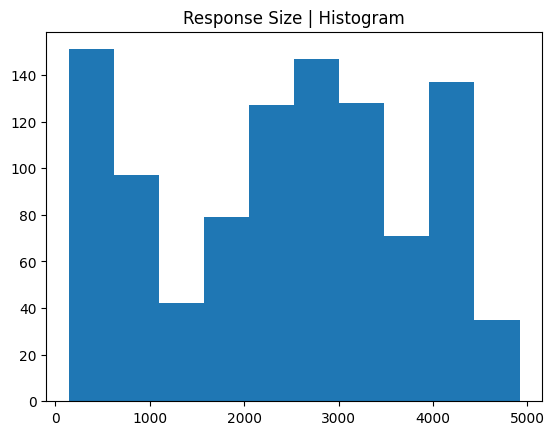

In [126]:
plt.hist(sql_response_size)
plt.title('Response Size | Histogram')

#### --------------------------------------------------------------------------------------------------------------------

In [124]:
sql_status_code = db.query_executer('select status_code from ngnix;')
sql_status_code[:5]

[(200,), (301,), (200,), (200,), (500,)]

In [125]:
temp = []

for i in sql_status_code:
    temp.append(i[0])

sql_status_code = temp

Text(0.5, 1.0, 'Status Code | Histogram')

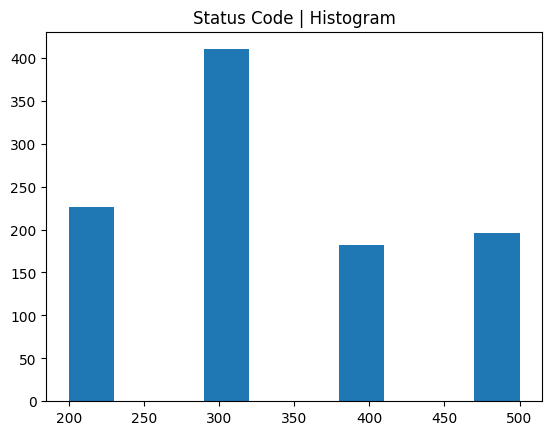

In [127]:
plt.hist(sql_status_code)
plt.title('Status Code | Histogram')

#### --------------------------------------------------------------------------------------------------------------------

## MySQL to CSV and EXCEL Files

In [129]:
sql_2_df = pd.read_sql_query('select * from ngnix;', db.db)
sql_2_df.to_csv('slq_test_db.csv', index=False)
sql_2_df.to_excel('slq_test_db_excel.xlsx', index=False)

C:\Users\MTK22\AppData\Local\Temp\ipykernel_6740\784449390.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql_2_df = pd.read_sql_query('select * from ngnix;', db.db)
